# Introduction

Building a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.


In [ ]:
# Restart the Kernel after you execute this command
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.ToTensor()

# Create training set and define training dataloader
training_set = torchvision.datasets.MNIST(root= './data', 
                                          train = True, 
                                          transform = transform, 
                                          download = True)

train_loader = torch.utils.data.DataLoader(training_set,
                                          batch_size=5,
                                          shuffle=True)

# Create test set and define test dataloader
test_set = torchvision.datasets.MNIST(root= './data', 
                                          train = False,           # for the test dataset, train=False
                                          transform = transform, 
                                          download = True)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=5,
                                          shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Explore the Dataset

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

1


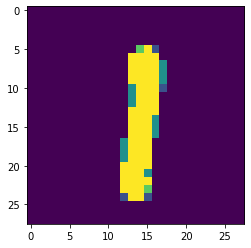

1


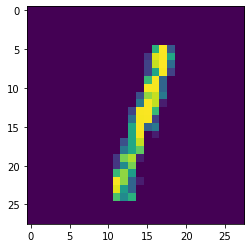

6


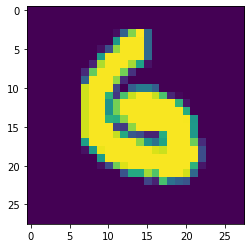

1


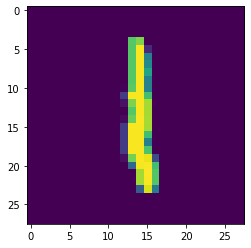

7


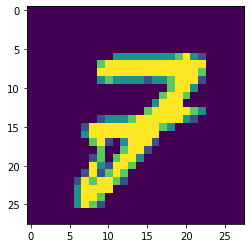

In [4]:
# Explore data
show5(test_loader)

In [5]:
sample = iter(train_loader)
images, labels = next(sample)

print(f"Images batch shape: {images.shape}")  # [batch_size, channels, height, width]


Images batch shape: torch.Size([5, 1, 28, 28])


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [6]:
## YOUR CODE HERE ##
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()   #1D vector per image
        self.layer_1 = nn.Linear(28*28,256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 10)   #output layer (10 classes)
        
    def forward(self,x):
        x = self.flatten(x)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)                      #no softmax layer because CrossEntropyLoss recieves logits
        return x
    

In [7]:
model = Network()
model

Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=10, bias=True)
)

#### Specify loss and optimizer

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)  

Using device: cuda


Network(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=10, bias=True)
)

Plot the training loss (and validation loss/accuracy, if recorded).

In [ ]:
def train_model(model, epochs=12):
    model.to(device)
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for batch_id, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            #forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            #bwd pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
        
    return train_losses


In [11]:
train_losses = train_model(model, epochs=12)

Epoch 1/12, Loss: 0.2023
Epoch 2/12, Loss: 0.0991
Epoch 3/12, Loss: 0.0728
Epoch 4/12, Loss: 0.0614
Epoch 5/12, Loss: 0.0529
Epoch 6/12, Loss: 0.0459
Epoch 7/12, Loss: 0.0453
Epoch 8/12, Loss: 0.0390
Epoch 9/12, Loss: 0.0380
Epoch 10/12, Loss: 0.0371
Epoch 11/12, Loss: 0.0319
Epoch 12/12, Loss: 0.0326


In [12]:
def plot(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.show()


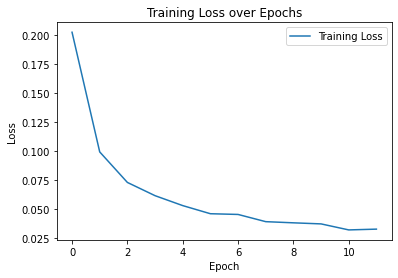

In [13]:
plot(train_losses)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [18]:
## YOUR CODE HERE ##
def test_model(model):
    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")


In [19]:
test_model(model)

Test Accuracy: 97.96%


## Saving your model

In [ ]:
torch.save(model.state_dict(), "model.pth")